# Result_Fig4_2 : Salary CID with data availability

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')

sys.path.insert(1, p)
sys.path.insert(1, pp)

In [2]:
import pandas as pd
from utils.salary import *
import matplotlib.pyplot as plt
import numpy as np
from constants import CONSTANTS
from statsmodels.api import OLS, add_constant
import pickle

In [3]:
s_path = CONSTANTS.s_salary_result_path
file_list = os.listdir(f'{s_path}/agg')
df = pd.read_json(f'{s_path}/agg/{file_list[0]}')

In [4]:
t_path = CONSTANTS.s_tag_info_path
file_list = os.listdir(f'{t_path}/agg')
with open(f'{t_path}/agg/{file_list[0]}', 'rb') as f:
    tag_info = pickle.load(f)

In [5]:
df = df.reset_index().rename(columns={'index':'year'})

In [6]:
df = df.sort_values(by = 'year').reset_index(drop=True)

In [7]:
df

,year,clojure,f#,elixir,erlang,perl,ruby,scala,rust,go,...,zig,apex,nim-lang,raku,ada,prolog,gdscript,vb.net,micropython,zephyr-rtos
0,2019,90000.0,80000.0,76000.0,71000.0,NaN,75000,78000,72000,80000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,NaN,NaN,NaN,76000.0,71000,76000,74000,74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,95000.0,81037.0,80077.0,80077.0,80000.0,80000,77832,77530,75669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,106644.0,95526.0,92959.0,103000.0,90073.0,93000,92780,87047,89204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,96381.0,99311.0,96381.0,99492.0,94540.0,98522,96381,87012,92760,...,103611.0,81552.0,80000.0,79448.0,71500.0,70000.0,69608.0,65000.0,NaN,NaN
5,2024,95541.0,80555.0,96000.0,100636.0,90000.0,90221,88619,76292,76433,...,75332.0,82500.0,94924.0,NaN,42584.0,43327.0,60684.0,63694.0,75184.0,64444.0


In [8]:
def get_CID_ratio_rel_df(df, year) : 
    year_list = [year-3, year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    valid_langs = df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index
    filtered_df = df_salary[df_salary['lang'].isin(valid_langs)].copy()

    # 언어별로 연도 정렬 후 상대 변화율(성장률) 계산
    filtered_df.sort_values(by=['lang', 'year'], inplace=True)
    filtered_df['growth_rate'] = filtered_df.groupby('lang')['salary'].pct_change()

    # growth_rate의 이차 차분 = CID 계산
    filtered_df['CID'] = filtered_df.groupby('lang')['growth_rate'].diff()
    filtered_df['CID'] = filtered_df.groupby('lang')['CID'].diff()

    # 최종 정리: CID 계산이 가능한 연도만 남김
    filtered_df = filtered_df.dropna(subset=['growth_rate', 'CID']).reset_index(drop=True)


    return filtered_df




In [9]:
def filter_df( df ) :
    tot_filtered_df = pd.DataFrame()
    for year in [ 2022, 2023, 2024] : 
        filtered_df = get_CID_ratio_rel_df(df, year)
        tot_filtered_df = pd.concat([tot_filtered_df, filtered_df], axis = 0)
    
        tot_exist_df = tot_filtered_df[tot_filtered_df['lang'].isin(tot_filtered_df['lang'].value_counts()[lambda x: x == len([ 2022, 2023, 2024])].index)].copy()
        tot_exist_df=  tot_exist_df.sort_values(by = ['year', 'CID'], ascending=[False, True])
    return tot_exist_df

In [10]:
tot_df_rl = filter_df(df )

[2019, 2020, 2021, 2022]
[2020, 2021, 2022, 2023]
[2021, 2022, 2023, 2024]


In [11]:
def draw_rate_of_change_diff_plot():
    tag_list = list(tot_df_rl['lang'].unique())
    x_dict = dict()
    for tag_str in tag_list:
        tags = tag_str.split("/")
        x_value = sum([int(tag_info[tag])
                        for tag in tags])
        x_dict[tags[0]] = np.log(x_value)
    return x_dict
        

In [12]:
x_value = draw_rate_of_change_diff_plot()

In [13]:
x_value_df = pd.DataFrame(list(x_value.items()), columns=['lang', 'log_db_count'])
x_value_df.head()


,lang,log_db_count
0,r,13.051454
1,javascript,14.698014
2,java,14.434387
3,kotlin,11.270408
4,typescript,12.182430


In [14]:
cid_cnt_df = pd.merge(tot_df_rl, x_value_df, on = ['lang'])

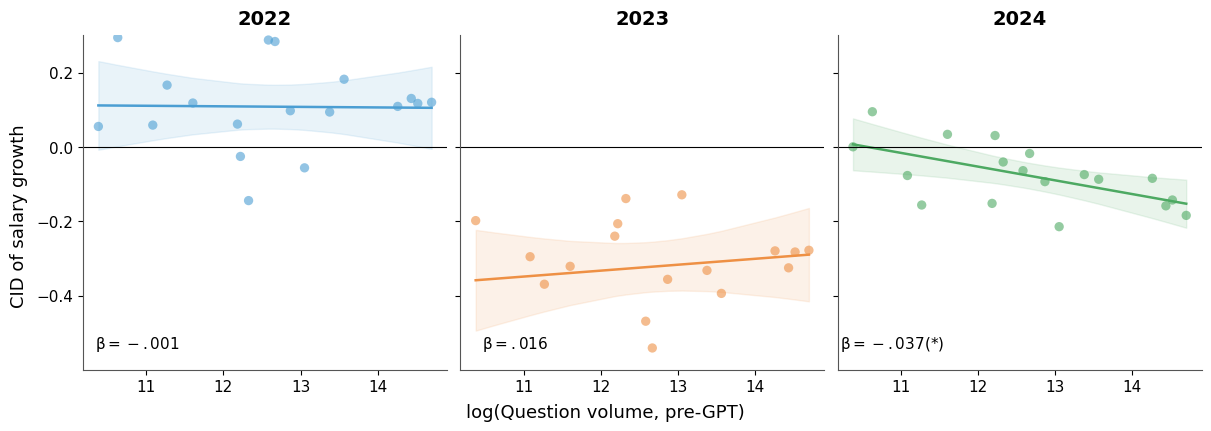

In [15]:
colors = {
    2022: '#4b9ed3',  # muted blue
    2023: '#ee9044',  # soft orange
    2024: '#4da962'   # balanced green
}


fig, axs = plt.subplots(1, 3, figsize=(12, 4.2), sharex=True, sharey=True, constrained_layout=True)
reg_summary = []

for i, year in enumerate(sorted(cid_cnt_df['year'].unique())):
    sub = cid_cnt_df[cid_cnt_df['year'] == year].sort_values("log_db_count")
    x = sub['log_db_count']
    y = sub['CID']

    X = add_constant(x)
    model = OLS(y, X).fit()
    pred = model.get_prediction(X)
    ci = pred.conf_int(alpha=0.05)
    mean = pred.predicted_mean
    color = colors[year]

    axs[i].fill_between(x, ci[:, 0], ci[:, 1], color=color, alpha=0.12)
    axs[i].plot(x, mean, color=color, lw=1.8)
    axs[i].scatter(x, y, color=color, s=45, alpha=0.6, edgecolor='none')  # 점 약간 확대
    axs[i].axhline(y=0, color='black', linewidth=0.8)
    axs[i].set_title(f"{year}", fontsize=14, fontweight='bold', pad=8)  # 제목 크게
    axs[i].tick_params(axis='x', labelsize=11)
    axs[i].tick_params(axis='y', labelsize=11)
    axs[i].grid(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_linewidth(0.8)
    axs[i].spines['bottom'].set_linewidth(0.8)
    axs[i].spines['left'].set_color('#555555')
    axs[i].spines['bottom'].set_color('#555555')
    axs[i].set_xlim(x.min() - 0.2, x.max() + 0.2)
    axs[i].set_ylim(-0.6, 0.3)
    axs[i].set_yticks([-0.4, -0.2, 0, 0.2])

    slope = model.params.iloc[1]
    ci_low, ci_high = model.conf_int(alpha=0.05).loc['log_db_count']
    pval = model.pvalues['log_db_count']
    reg_summary.append({
        'Year': year,
        'Slope': slope,
        '95% CI (low)': ci_low,
        '95% CI (high)': ci_high,
        'p-value': pval
    })
    sig = '(*)' if pval <0.05 else ''
    axs[i].text(0.15, 0.05, rf"$\mathrm{{\beta}} = {slope:.3f}{sig}$".replace("-0.", "-.").replace("0.", "."),
        ha='center', va='bottom',
        transform=axs[i].transAxes, fontsize=11)

reg_df = pd.DataFrame(reg_summary)

fig.supxlabel("log(Question volume, pre-GPT)", fontsize=13)
fig.supylabel("CID of salary growth", fontsize=13)

plt.savefig(f"./fig/C_Result_Fig4_2.png", dpi=300, bbox_inches='tight')
plt.show()
